In [11]:
import os
import statistics
from typing import Dict, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches


In [12]:
def load_csv_results():
    normal_scenarios = ["data_cleaning", "data_corruption"]
    normal_datasets = ["reviews_10x"]
    data_loadings = ["fast_loading"]
    featurizations = ["featurization_2"]

    models = ["logistic_regression"]
    exec_strategies = ["dfs", "bfs"]
    variant_counts = list(range(0, 17, 2))
    result_df = None
    for scenario in normal_scenarios:
        for dataset in normal_datasets:
            for data_loading in data_loadings:
                for featurization in featurizations:
                    for model in models:
                        for exec_strategy in exec_strategies:
                            flag = exec_strategy == "bfs"
                            for variant_count in variant_counts:
                                filepath = f"{os.getcwd()}/memory-benchmark-results/" \
                                           f"results-{scenario}-{dataset}-{data_loading}-{featurization}-{model}-" \
                                           f"{flag}-{variant_count}.csv"
                                new_df = pd.read_csv(filepath)
                                median_no_opt = new_df['total_exec_duration_without_opt'].median()
                                new_df['median_no_opt'] = median_no_opt
                                median_opt = new_df['total_exec_duration_with_opt'].median()
                                new_df['median_opt'] = median_opt
                                new_df['exec_strategy'] = exec_strategy
                                pretty_scenario_names = {
                                    'feature_importance': 'feature importance',
                                    'operator_impact': 'operator impact',
                                    'data_cleaning': 'data cleaning',
                                    'data_corruption': 'data corruption',
                                }
                                new_df['pretty_scenario'] = new_df['scenario'].map(pretty_scenario_names)
                                new_df['scenario_and_strategy'] = new_df['pretty_scenario'] + " " + new_df['exec_strategy']

                                new_df['exec_strategy'] = exec_strategy
                                new_df['median_opt_plan_generation'] = new_df['opt_what_if_plan_generation'].median()
                                new_df['median_opt_mqo'] = new_df['opt_what_if_query_optimization_duration'].median()
                                new_df['median_opt_other_runtime'] = new_df['total_exec_duration_with_opt'].median() - \
                                                                     new_df['opt_original_pipeline_without_importing_and_monkeypatching'].median() - \
                                                                     new_df['opt_original_pipeline_importing_and_monkeypatching'].median() - new_df['opt_what_if_execution'].median()
                                median_speedup = median_no_opt / median_opt
                                new_df['median_speedup'] = median_speedup
                                new_df['opt_original_pipeline_estimated'] = new_df['opt_original_pipeline_estimated'].median()
                                new_df['median_original_with_instrum'] = (new_df['opt_original_pipeline_without_importing_and_monkeypatching'] +
                                                                          new_df['opt_original_pipeline_importing_and_monkeypatching']).median()
                                new_df['median_model_training_opt'] = new_df['opt_original_pipeline_model_training'].median() \
                                                                      + new_df['opt_what_if_execution_combined_model_training'].median()
                                new_df['median_model_training_no_opt'] = new_df['opt_original_pipeline_model_training'].median() \
                                                                      + new_df['no_opt_what_if_execution_combined_model_training'].median()
                                new_df['median_no_opt_wo_orig'] = new_df['median_no_opt'] - new_df['median_original_with_instrum']
                                new_df['median_opt_wo_orig'] = new_df['median_opt'] - new_df['median_original_with_instrum']
                                new_df['median_opt_wo_training'] = new_df['median_opt'] - new_df['median_model_training_opt']
                                new_df['median_no_opt_wo_training'] = new_df['median_no_opt'] - \
                                                                      new_df['median_model_training_no_opt']
                                new_df['median_speedup_excluding_model_training'] = new_df['median_no_opt_wo_training'] / \
                                                                                    new_df['median_opt_wo_training']
                                # for column in new_df.columns:
                                #     if column.startswith("analysis_result"):
                                #         new_df[column] = median_no_opt / new_df[column].median()
                                new_df['max_possible_speedup'] = new_df['variant_actual_count'] / 2
                                new_df['base_max_memory'] = new_df['result_df_base_memory_max_psutil_rss'].median()
                                new_df['no_opt_max_memory'] = new_df['result_df_no_opt_memory_max_psutil_rss'].median()
                                new_df['opt_max_memory'] = new_df['result_df_opt_memory_max_psutil_rss'].median()
                                new_df['opt_memory_overhead'] = new_df['opt_max_memory'] / new_df['base_max_memory']
                                new_df['no_opt_memory_overhead'] = new_df['no_opt_max_memory'] / new_df['base_max_memory']
                                new_df = new_df[['median_no_opt', 'median_opt', 'median_speedup', 'median_original_with_instrum',
                                                 'median_speedup_excluding_model_training',
                                                 'median_no_opt_wo_orig', 'median_opt_wo_orig',
                                                 'median_opt_plan_generation', 'median_opt_mqo', 'median_opt_other_runtime',
                                                 'opt_original_pipeline_estimated', 'variant_actual_count', 'variant_factor',
                                                 'max_possible_speedup', 'scenario', 'dataset',
                                                 'data_loading', 'featurization', 'model', 'exec_strategy',
                                                 'base_max_memory', 'no_opt_max_memory', 'opt_max_memory',
                                                 'opt_memory_overhead', 'no_opt_memory_overhead',
                                                 'scenario_and_strategy']]
                                new_df = new_df.head(1)
                                new_df = new_df.round(2)
                                if result_df is None:
                                    result_df = new_df
                                else:
                                    result_df = pd.concat([result_df, new_df], axis=0)
    return result_df

In [13]:
median_results = load_csv_results()

In [14]:
median_results_ordered_by_variant_count = median_results.sort_values(by=['variant_actual_count', 'exec_strategy'])
median_results_ordered_by_variant_count.to_csv(f"{os.getcwd()}/memory-benchmark-results/memory_speedup_"
                                                f"overview_ordered_by_variant_count.csv", index=True)
median_results_ordered_by_variant_count


,median_no_opt,median_opt,median_speedup,median_original_with_instrum,median_speedup_excluding_model_training,median_no_opt_wo_orig,median_opt_wo_orig,median_opt_plan_generation,median_opt_mqo,median_opt_other_runtime,...,data_loading,featurization,model,exec_strategy,base_max_memory,no_opt_max_memory,opt_max_memory,opt_memory_overhead,no_opt_memory_overhead,scenario_and_strategy
0,43754.58,43830.07,1.00,43686.90,1.00,67.67,143.17,0.03,0.65,143.22,...,fast_loading,featurization_2,logistic_regression,bfs,1.584996e+09,1.869459e+09,1.700741e+09,1.07,1.18,data cleaning bfs
0,45040.66,44803.95,1.01,44661.77,1.01,378.89,142.18,0.05,0.61,142.13,...,fast_loading,featurization_2,logistic_regression,bfs,1.585144e+09,1.633292e+09,1.632170e+09,1.03,1.03,data corruption bfs
0,43931.68,43843.70,1.00,43694.32,1.00,237.36,149.38,0.04,0.63,149.30,...,fast_loading,featurization_2,logistic_regression,dfs,1.585963e+09,1.926017e+09,1.925231e+09,1.21,1.21,data cleaning dfs
0,45324.01,45367.32,1.00,45222.56,1.00,101.45,144.77,0.05,0.63,144.66,...,fast_loading,featurization_2,logistic_regression,dfs,1.589215e+09,1.703752e+09,1.703817e+09,1.07,1.07,data corruption dfs
0,400749.61,161356.00,2.48,44079.91,2.55,356669.70,117276.09,0.45,40.49,173.08,...,fast_loading,featurization_2,logistic_regression,bfs,1.589711e+09,2.480165e+09,3.451400e+09,2.17,1.56,data cleaning bfs
0,446717.18,143232.01,3.12,44542.52,3.11,402174.65,98689.49,0.21,18.60,219.60,...,fast_loading,featurization_2,logistic_regression,bfs,1.586045e+09,2.470175e+09,3.018854e+09,1.90,1.56,data corruption bfs
0,404081.35,162613.79,2.48,44123.32,2.55,359958.03,118490.47,0.45,40.50,373.77,...,fast_loading,featurization_2,logistic_regression,dfs,1.585709e+09,2.335900e+09,3.757560e+09,2.37,1.47,data cleaning dfs
0,447569.67,140515.55,3.19,44121.72,3.17,403447.96,96393.83,0.22,18.51,27.62,...,fast_loading,featurization_2,logistic_regression,dfs,1.584869e+09,2.382696e+09,2.686079e+09,1.69,1.50,data corruption dfs
0,754559.66,235305.31,3.21,44100.30,3.34,710459.35,191205.00,0.68,87.36,285.49,...,fast_loading,featurization_2,logistic_regression,bfs,1.638146e+09,2.526089e+09,4.733522e+09,2.89,1.54,data cleaning bfs
0,823730.18,165735.07,4.97,44683.40,4.94,779046.78,121051.67,0.41,40.64,-92.45,...,fast_loading,featurization_2,logistic_regression,bfs,1.589834e+09,2.523169e+09,3.906839e+09,2.46,1.59,data corruption bfs


In [5]:
def speedup_memory_scatter_plot(data, title, x_column, y_column, groupby_column, x_col_name='memory', y_col_name='speedup'):
    unique_groupby_values = list(data[groupby_column].unique())
    unique_groupby_values.sort()
    colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
    colors_and_values = list(zip(colors, unique_groupby_values))
    fig, ax = plt.subplots()
    for color, groupby_value in colors_and_values:
        filtered_data = data[data[groupby_column] == groupby_value]
        x = filtered_data[x_column]
        y = filtered_data[y_column]
        ax.scatter(x, y, c=color, label=groupby_value,
                   alpha=1., edgecolors='none')

    if x_col_name == 'variants' and y_col_name == 'memory':
        plt.plot([1, 64], [1, 64], '--', color='grey', label='limit')

    ax.legend(fontsize=15, ncol=1)
    ax.grid(True)
    plt.ylabel(y_col_name, fontsize=26)
    plt.xlabel(x_col_name, fontsize=26)
    if x_col_name == 'variants' and y_col_name == 'memory':
        plt.ylim(0, 64)
        plt.xlim(0, 64)

    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)

    print(plt.yticks()[0])
    plt.yticks(list(plt.yticks()[0]) + [1])

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

[ 0.  2.  4.  6.  8. 10. 12.]


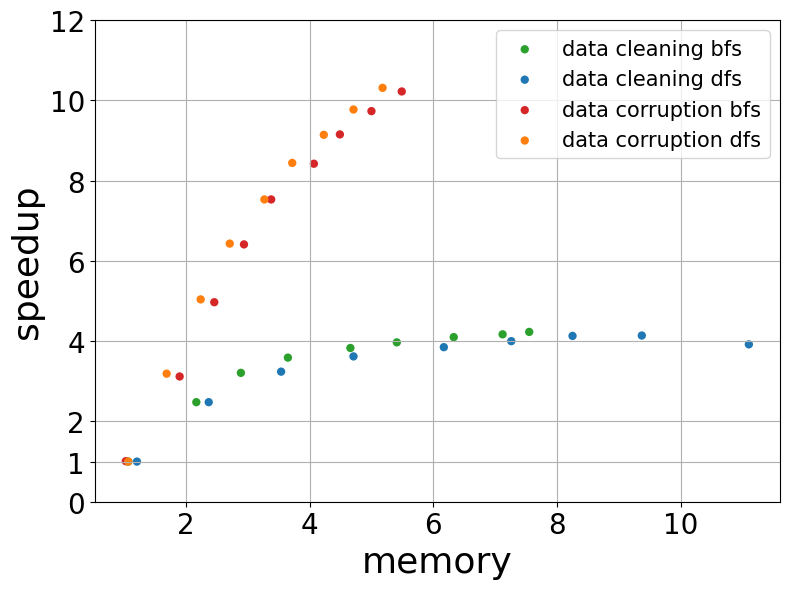

In [6]:
speedup_memory_scatter_plot(median_results, 'speedup_and_memory_per_exec_strategy', 'opt_memory_overhead', 'median_speedup', 'scenario_and_strategy')

[ 0. 20. 40. 60. 80.]


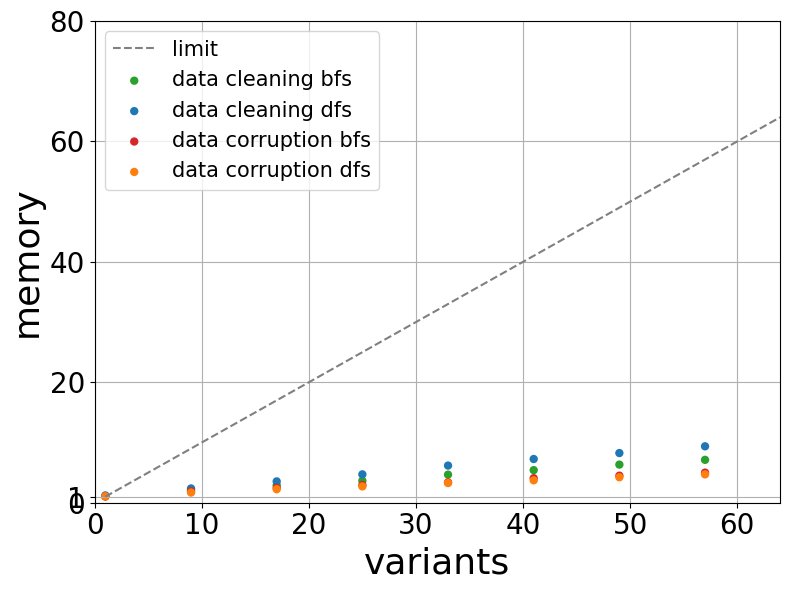

In [7]:
speedup_memory_scatter_plot(median_results, 'memory_variants_per_exec_strategy', 'variant_actual_count', 'opt_memory_overhead', 'scenario_and_strategy', 'variants', 'memory')

[ 0.  2.  4.  6.  8. 10. 12.]


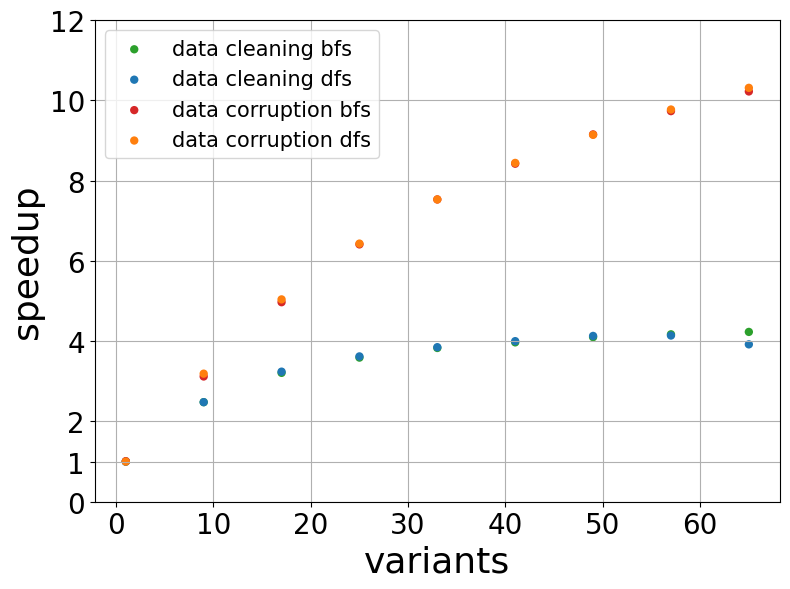

In [8]:
speedup_memory_scatter_plot(median_results, 'speedup_per_exec_strategy', 'variant_actual_count', 'median_speedup', 'scenario_and_strategy', 'variants')


In [9]:
def speedup_box_plot(data, title, with_outliers, group_col_1, group_col_2, plot_column, absolute_times):
    fig, ax = plt.subplots()

    classes_col1 = list(data[group_col_1].unique())
    classes_col2 = list(data[group_col_2].unique())

    if absolute_times is False:
        colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
    else:
        colors = ['tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange']
    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)


    position = 1
    for group1_index, group1_val in enumerate(classes_col1):
        filtered1_data = data[data[group_col_1] == group1_val]

        for group2_index, (group2_val, color) in enumerate(zip(classes_col2, colors)):
            filtered2_data = filtered1_data[filtered1_data[group_col_2] == group2_val]
            values_to_plot = filtered2_data[plot_column]
            if absolute_times is False:
                box = plt.boxplot([values_to_plot], positions=[position], widths=0.6, showfliers=with_outliers)
                set_box_color(box, color)
            else:
                patch_artist = group2_index % 2 == 1
                box = plt.boxplot([values_to_plot], positions=[position], widths=0.6, showfliers=with_outliers, patch_artist=patch_artist)
                set_box_color(box, color)
                if patch_artist:
                    plt.setp(box['medians'], color='black')
            position += 1
        position += 1
    # ax.legend(fontsize=15, ncol=1)
    # ax.grid(True)
    plt.gca().yaxis.grid(True, linestyle='-.')
    if absolute_times is True:
        plt.ylabel('runtime [s]', fontsize=26)
        plt.ylim(0, None)
    else:
        plt.ylabel('speedup', fontsize=20)
        if with_outliers is False:
            plt.ylim(0, None)
    # plt.xlabel('# rows', fontsize=26)
    # plt.xlim(0, 45)
    ax.set_xticks([len(classes_col2) / 2 + (len(classes_col2) + 1) * group1_index for group1_index, _ in enumerate(classes_col1)])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels(classes_col1, fontsize=18)

    for class2, color in zip(classes_col2, colors):
        plt.plot([], c=color, label=class2)
    plt.legend(fontsize=15)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

In [10]:
# Without outliers
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
speedup_box_plot(pretty_scenario_names, 'speedup_per_scenario_per_dataset_without_outliers', False, 'scenario', 'dataset', 'median_speedup', False)

KeyError: 'variant_count_including_orig'

In [ ]:
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
featurization_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['featurization'] = pretty_scenario_names['featurization'].map(featurization_map)
speedup_box_plot(pretty_scenario_names, 'speedup_per_scenario_per_featurization_without_outliers', False, 'scenario', 'featurization', 'median_speedup', False)

In [ ]:
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
model_map = {
    'logistic_regression': 'log. regression',
    'xgboost': 'xgboost',
    'neural_network': 'nn',
    'image': 'cnn',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['model'] = pretty_scenario_names['model'].map(model_map)
speedup_box_plot(pretty_scenario_names, 'speedup_per_scenario_per_model_without_outliers', False, 'scenario', 'model', 'median_speedup', False)

In [ ]:
def speedup_bar_plot(data, title, with_outliers, group_col_1, group_col_2, plot_column, absolute_times, orig_pipeline_col):
    fig, ax = plt.subplots()
    # ax.set_yscale('log')

    classes_col1 = list(data[group_col_1].unique())
    classes_col2 = list(data[group_col_2].unique())

    if absolute_times is False:
        colors = ['tab:green', 'tab:blue', 'tab:red', 'tab:orange', 'tab:pink', 'tab:purple']
    else:
        colors = ['tab:green', 'tab:green', 'tab:blue', 'tab:blue', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange']

    position = 1

    def pairwise(iterable):
        "s -> (s0, s1), (s2, s3), (s4, s5), ..."
        a = iter(iterable)
        return zip(a, a)

    for group1_index, group1_val in enumerate(classes_col1):
        filtered1_data = data[data[group_col_1] == group1_val]

        for (group2_val_without, color_without), (group2_val_with, color_with) \
                in pairwise(zip(classes_col2, colors)):
            filtered2_data_without = filtered1_data[filtered1_data[group_col_2] == group2_val_without]
            values_to_plot_without = filtered2_data_without[plot_column]
            filtered2_data_with = filtered1_data[filtered1_data[group_col_2] == group2_val_with]
            values_to_plot_with = filtered2_data_with[plot_column]

            orig_pipeline = filtered2_data_with[orig_pipeline_col]
            orig_pipeline_without = filtered2_data_without[orig_pipeline_col]


            if len(values_to_plot_without) > 0:
                values_diff = values_to_plot_without / values_to_plot_with
                best_case_arg_index = np.argmax(values_diff)
                max_without = values_to_plot_without.iloc[best_case_arg_index]
                max_with = values_to_plot_with.iloc[best_case_arg_index]

                orig_pipeline_value = orig_pipeline.iloc[best_case_arg_index]
                orig_pipeline_value_without = orig_pipeline_without.iloc[best_case_arg_index]
                assert orig_pipeline_value == orig_pipeline_value_without

                bars = plt.bar([position], orig_pipeline_value, width=1., color='black', hatch="/", edgecolor='white')
                bars = plt.bar([position], max_without, width=1., color=color_without, hatch="/", edgecolor='white', bottom=orig_pipeline_value)
                # access the bar attributes to place the text in the appropriate location
                # for bar in bars:
                #     yval = bar.get_height()
                #     plus_y_loc = 5
                #     if max_with + 5 >= max_without:
                #         plus_y_loc = 15
                #     plt.text(bar.get_x(), yval + plus_y_loc, round(yval))
                bars = plt.bar([position + 1], orig_pipeline_value, width=1., color='black', hatch=None, edgecolor='white')
                bars = plt.bar([position + 1], max_with, width=1., color=color_with, hatch=None, edgecolor='white', bottom=orig_pipeline_value)
                # for bar in bars:
                #     yval = bar.get_height()
                #     plt.text(bar.get_x(), yval + 5, round(yval))
            position += 2
        position += 2
    # ax.legend(fontsize=15, ncol=1)
    # ax.grid(True)
    plt.gca().yaxis.grid(True, linestyle='-.')
    if absolute_times is True:
        plt.ylabel('runtime [s]', fontsize=26)
        plt.ylim(0, None)
    else:
        plt.ylabel('speedup', fontsize=20)
        if with_outliers is False:
            plt.ylim(0, None)
    # plt.xlabel('# rows', fontsize=26)
    plt.xlabel('dataset + #rows', fontsize=20)
    plt.xlim(0, None)
    ax.set_xticks([4 + (len(classes_col2) + 2) * group1_index for group1_index, _ in enumerate(classes_col1)])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels(classes_col1, fontsize=18)

    handles1 = []
    handles2 = []
    # handles.append(patches.Patch( facecolor='grey',hatch="/",label='no opt.'))
    # handles.append(patches.Patch( facecolor='grey',hatch=None,label='opt.'))
    for class_index, (class2, color) in enumerate(zip(classes_col2, colors)):
        # class2_name = class2.replace(" no opt.", "")
        if (class_index % 2) == 0:
            handles1.append(patches.Patch(facecolor=color,edgecolor='white', hatch="/",label=class2))
        else:
            handles2.append(patches.Patch(facecolor=color,hatch=None,label=class2))

        # patches.Patch( facecolor='grey',hatch="/",label='no. opt')
        # line = plt.plot([], c=color, label=class2_name)[0]
        # handles.append(line)
    plt.legend(fontsize=12, handles=handles1 + handles2, loc="upper left", ncol=2)

    plt.gcf().set_size_inches(8, 6)
    plt.tight_layout()

    current_directory = os.getcwd()
    output_directory = os.path.join(current_directory, r'figures')
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.gcf().savefig(f'./figures/{title}.pdf', dpi=300)
    plt.show()

scenario_names = {
    'feature_importance': 'feature importance',
    'operator_impact': 'operator impact',
    'data_cleaning': 'data cleaning',
    'data_corruption': 'data corruption',
}
model_map = {
    'logistic_regression': 'log. regression',
    'xgboost': 'xgboost',
    'neural_network': 'nn',
    'image': 'cnn',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['model'] = pretty_scenario_names['model'].map(model_map)
pretty_scenario_names['run'] = pretty_scenario_names['model'].map(model_map)

with_opt = pretty_scenario_names.copy()
with_opt['runtime'] = with_opt['median_opt_wo_orig'] / 1000
with_opt['scenario'] = with_opt['scenario'] + " opt."

no_opt = pretty_scenario_names.copy()
no_opt['runtime'] = no_opt['median_no_opt_wo_orig'] / 1000
no_opt['scenario'] = no_opt['scenario'] + " no opt."

data_set_sort_order = {
    'healthcare': 0,
    'sneakers': 1,
    'folktables': 2,
    'cardio': 3,
    'reviews': 4,
}
scenario_sort_order = {
    'feature importance no opt.': 0,
    'feature importance opt.': 1,
    'operator impact no opt.': 2,
    'operator impact opt.': 3,
    'data corruption no opt.': 4,
    'data corruption opt.': 5,
    'data cleaning no opt.': 6,
    'data cleaning opt.': 7
}
data_set_row_count_map = {
    'healthcare': 'healthcare\n(#1k)',
    'sneakers': 'sneakers\n(#6k)',
    'folktables': 'folktables\n(#30k)',
    'cardio': 'cardio\n(#70k)',
    'reviews': 'reviews\n(#100k)',
}
opt_and_no_opt = pd.concat([with_opt, no_opt], axis=0)
opt_and_no_opt["dataset_sort_order"] = opt_and_no_opt["dataset"].map(data_set_sort_order)
opt_and_no_opt["scenario_sort_order"] = opt_and_no_opt["scenario"].map(scenario_sort_order)
opt_and_no_opt = opt_and_no_opt.sort_values(["dataset_sort_order", "scenario_sort_order"])
opt_and_no_opt['dataset'] = opt_and_no_opt['dataset'].map(data_set_row_count_map)
opt_and_no_opt['median_original_with_instrum'] = opt_and_no_opt['median_original_with_instrum'] / 1000
speedup_bar_plot(opt_and_no_opt, 'runtime_w_and_wo_per_dataset_per_scenario_without_outliers', False, 'dataset', 'scenario', 'runtime', True, 'median_original_with_instrum')

In [ ]:
# Without outliers
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
speedup_box_plot(pretty_scenario_names, 'speedup_wo_training_per_scenario_per_dataset_without_outliers', False, 'scenario', 'dataset', 'median_speedup_excluding_model_training', False)


In [ ]:
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
featurization_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['featurization'] = pretty_scenario_names['featurization'].map(featurization_map)
speedup_box_plot(pretty_scenario_names, 'speedup_wo_training_per_scenario_per_featurization_without_outliers', False, 'scenario', 'featurization', 'median_speedup_excluding_model_training', False)

In [ ]:
# FIXME: Is w/o training bugged?
scenario_names = {
    'feature_importance': 'feature\nimportance',
    'operator_impact': 'operator\nimpact',
    'data_cleaning': 'data\ncleaning',
    'data_corruption': 'data\ncorruption',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
model_map = {
    'logistic_regression': 'log. regression',
    'xgboost': 'xgboost',
    'neural_network': 'nn',
    'image': 'cnn',
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['model'] = pretty_scenario_names['model'].map(model_map)
speedup_box_plot(pretty_scenario_names, 'speedup_wo_training_per_scenario_per_model_without_outliers', False, 'scenario', 'model', 'median_speedup_excluding_model_training', False)

In [ ]:
data_set_join_info_map = {
    'healthcare': 'healthcare\n(fuzzy join,\nwith text)',
    'sneakers': 'sneakers\n(1 join,\nwith images)',
    'folktables': 'folktables\n(0 joins,\nno text)',
    'cardio': 'cardio\n(2 joins,\nno text)',
    'reviews': 'reviews\n(3 joins,\nwith text)',
}
for scenario_key, scenario_value in list(scenario_names.items()):
    min_variants = min(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    max_variants = max(median_results[median_results['scenario'] == scenario_key]['variant_count_including_orig'])
    scenario_names[scenario_key] = scenario_value + f"\n# {min_variants}-{max_variants}"
featurization_map = {
    'featurization_0': 'desc featur. 0',
    'featurization_1': 'desc featur. 1',
    'featurization_2': 'desc featur. 2',
    'featurization_3': 'desc featur. 3',
    'featurization_4': 'desc featur. 4',
    'image': 'desc featur. img'
}
pretty_scenario_names = median_results.copy(deep=True)
pretty_scenario_names['scenario'] = pretty_scenario_names['scenario'].map(scenario_names)
pretty_scenario_names['dataset'] = pretty_scenario_names['dataset'].map(data_set_join_info_map)
pretty_scenario_names['featurization'] = pretty_scenario_names['featurization'].map(featurization_map)
speedup_box_plot(pretty_scenario_names, 'speedup_wo_training_per_dataset_per_featurization_without_outliers', False, 'dataset', 'featurization', 'median_speedup_excluding_model_training', False)

In [ ]:
print("max other runtime is calculated by using total runtime, substracting orig execution and instrumentation, and "
      "substracting what-if combined plan execution")
print()

print(f"all datasets: max optimization duration: {median_results['median_opt_mqo'].max()}")
print(f"all datasets: max variant generation: {median_results['median_opt_plan_generation'].max()}")
print(f"all datasets: max other runtime: {median_results['median_opt_other_runtime'].max()}")
print()

print(f"all datasets: p95 optimization duration: {median_results['median_opt_mqo'].quantile(.95)}")
print(f"all datasets: p95 variant generation: {median_results['median_opt_plan_generation'].quantile(.95)}")
print(f"all datasets: p95 other runtime: {median_results['median_opt_other_runtime'].quantile(.95)}")
print()

print(f"all datasets: p90 optimization duration: {median_results['median_opt_mqo'].quantile(.9)}")
print(f"all datasets: p90 variant generation: {median_results['median_opt_plan_generation'].quantile(.9)}")
print(f"all datasets: p90 other runtime: {median_results['median_opt_other_runtime'].quantile(.9)}")
print()

print(f"all datasets: median optimization duration: {median_results['median_opt_mqo'].median()}")
print(f"all datasets: median variant generation: {median_results['median_opt_plan_generation'].median()}")
print(f"all datasets: median other runtime: {median_results['median_opt_other_runtime'].median()}")
print()

print(f"all datasets: p5 optimization duration: {median_results['median_opt_mqo'].quantile(.05)}")
print(f"all datasets: p5 variant generation: {median_results['median_opt_plan_generation'].quantile(.05)}")
print(f"all datasets: p5 other runtime: {median_results['median_opt_other_runtime'].quantile(.05)}")
print()

print(f"all datasets: min optimization duration: {median_results['median_opt_mqo'].min()}")
print(f"all datasets: min variant generation: {median_results['median_opt_plan_generation'].min()}")
print(f"all datasets: min other runtime: {median_results['median_opt_other_runtime'].min()}")
print()